In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
import datetime as dt
from pathlib import Path
from typing import Sequence, Tuple, List

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 1 = INFO, 2 = WARNING, 3 = ERROR
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pickle
import contextlib

import platform 
import sys
import math

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, mixed_precision
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts, LearningRateSchedule
import torch

import matplotlib
import matplotlib.pyplot as plt         # ← for progress curves
from IPython.display import display, update_display, clear_output

from tqdm.auto import tqdm          # progress bars that work in Jupyter
from __future__ import annotations     # allows union types on Py <3.10


2025-06-18 20:05:51.560229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750269951.647043   12228 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750269951.677386   12228 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750269951.785182   12228 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750269951.785370   12228 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750269951.785376   12228 computation_placer.cc:177] computation placer alr

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # to deactivate gpu
# tf.config.set_visible_devices([], 'GPU') # to deactivate gpu

print("Python :", platform.python_version(), "\n")
print("TF GPUs :", tf.config.list_physical_devices('GPU'))
print("Torch   :", torch.__version__, "CUDA-OK:", torch.cuda.is_available())


Python : 3.10.18 

TF GPUs : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch   : 2.2.2+cu121 CUDA-OK: True


In [4]:
ticker = 'AAPL'

df = pd.read_csv(f"dfs training/merged_{ticker}.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth_norm
2025-01-02 13:30:00,250.5906,250.6435,250.5244,250.5753,2259.0,250.5001,250.6505,0,0.00,0.000,0.0
2025-01-02 13:31:00,250.5806,250.6317,250.5121,250.5606,2351.0,250.4854,250.6358,0,0.00,0.000,0.0
2025-01-02 13:32:00,250.5712,250.6200,250.4938,250.5453,2455.0,250.4701,250.6205,0,0.00,0.000,0.0
2025-01-02 13:33:00,250.5580,250.6094,250.4762,250.5347,2474.0,250.4595,250.6099,0,0.00,0.000,0.0
2025-01-02 13:34:00,250.5491,250.5994,250.4600,250.5168,2792.0,250.4416,250.5919,0,0.00,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 20:56:00,203.2500,203.3500,203.2450,203.3200,189023.0,203.2590,203.3810,0,1.99,0.942,0.0
2025-06-03 20:57:00,203.3200,203.4200,203.3050,203.3800,222383.0,203.3190,203.4410,0,1.99,0.882,0.0
2025-06-03 20:58:00,203.3800,203.4300,203.3322,203.3750,279702.0,203.3140,203.4360,0,1.99,0.887,0.0
2025-06-03 20:59:00,203.3700,203.4100,203.2500,203.3400,724307.0,203.2790,203.4010,0,1.99,0.922,0.0


In [5]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
label_col      = "signal_smooth_norm"

feature_cols   = ["open", "high", "low", "close", "volume"]
LOOK_BACK      = 60                                # minutes of history
N_FEATS        = len(feature_cols) * LOOK_BACK     # final feature length

import datetime as dt
rth_start      = dt.time(14, 30)                   # US cash-open in CET/CEST

from pathlib import Path
save_dir       = Path("dfs training")
ckpt_path      = save_dir / f"best_{ticker}.weights.h5"   # auto-per‐ticker

# dataset split proportions
TRAIN_PROP, VAL_PROP = 0.70, 0.15                 # → 0.15 test remainder


###############################################################################
# 1 ·  MODEL HYPER-PARAMETERS (tuned defaults)                                 #
###############################################################################
# ── architecture ───────────────────────────────────────────────────────
SHORT_UNITS        = 32      # double → better GPU fill, little over-fit risk
LONG_UNITS         = 96
DROPOUT_SHORT      = 0.20    # applied AFTER the LSTM layer
DROPOUT_LONG       = 0.15
REC_DROP_SHORT     = 0.0     # MUST be 0.0 for fused kernel
REC_DROP_LONG      = 0.0

# ── optimiser : cosine-decay-restarts ──────────────────────────────────
INITIAL_LR         = 4e-4    # slightly cooler for bigger network
FIRST_DECAY_EPOCHS = 3       # first valley arrives early
T_MUL              = 2.0
M_MUL              = 1.0
ALPHA              = 0.05
LOSS_FN            = "mse"
CLIPNORM           = 1.0

# ── training control ───────────────────────────────────────────────────
TRAIN_BATCH        = 16      # GPU now uses more threads; fits on 8-12 GB
VAL_BATCH          = 1
MAX_EPOCHS         = 200
EARLY_STOP_PATIENCE= 20
USE_FP16           = True




In [6]:
###############################################################################
# build_lstm_tensors                                                          #
# --------------------------------------------------------------------------- #
# Converts **one big minute-bar DataFrame (many days)** into two leakage-free #
# NumPy arrays ready for the stateful LSTM:                                   #
#                                                                             #
#   X  – design matrix; every row is a 60-min (or `look_back`) window         #
#        flattened to 1-D:  (look_back × n_features,)                         #
#   y  – the single-step-ahead target corresponding to the *last* row         #
#        in that window.                                                      #
#                                                                             #
# RULES ENFORCED                                                              #
# • Windows never cross midnight → yesterday’s RTH info can’t leak into the   #
#   first prediction of the new day.                                          #
# • The very first RTH window of the day uses ONLY pre-trade minutes.         #
# • Features are **standardised per day** (mean-0 / std-1) so levels &        #
#   volumes that drift day-to-day don’t leak statistics across sessions.      #
# • Output dtype = float32 (GPU-friendly & half the RAM of float64).          #
# • Entire routine is vectorised with `np.lib.stride_tricks.sliding_window_view`
#   ⇒ no Python loop over 391 minutes → 40× faster than naive for-loops.      #
###############################################################################

def build_lstm_tensors(
    df: pd.DataFrame,
    *,
    look_back: int,
    feature_cols: Sequence[str],
    label_col: str,
    rth_start: dt.time,                # e.g. 14:30 CET for US equities
    flatten: bool = True               # keep 2-D (N, L·F) by default
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    df : pd.DataFrame
        One-minute OHLCV bars **for many calendar days**.  DatetimeIndex
        must be tz-aware & strictly increasing (no duplicates).
    look_back : int
        Size of the sliding window in minutes (e.g. 60).
    feature_cols : list[str]
        Names of numeric feature columns to feed the network.
    label_col : str
        Name of the 1-step-ahead target column (already computed).
    rth_start : datetime.time
        Clock time that marks the first minute of **regular trading hours**.
        Every minute whose index.time ≥ rth_start is considered “tradable”.
    flatten : bool
        • True  →  X rows are 1-D vectors  (L·F,)  → matches our current
                   `make_day_dataset` reshape → lighter I/O.
        • False →  X rows keep shape  (L, F)     → nicer for exploratory
                   notebook charting, but slower to feed into tf.data.

    Returns
    -------
    X : np.ndarray (N, L·F)  *or* (N, L, F)
        Design matrix.  N = (#days × intraday minutes) − look_back.
    y : np.ndarray (N,)
        Targets aligned 1:1 with X rows.
    """

    X_rows, y_rows = [], []                    # collectors

    # 1. process *one calendar day* at a time (prevents inter-day leakage)
    for date, day_df in df.groupby(df.index.normalize()):

        day_df = day_df.sort_index()

        # 1-A. per-day standard-scaling of *features*
        day_df[feature_cols] = StandardScaler().fit_transform(
                                   day_df[feature_cols])

        feats_np  = day_df[feature_cols].to_numpy(dtype=np.float32)   # (T, F)
        label_np  = day_df[label_col]     .to_numpy(dtype=np.float32) # (T,)

        # Boolean mask of rows that belong to regular trading hours
        rth_mask = day_df.index.time >= rth_start
        if not rth_mask.any():                      # holiday / half-day
            continue

        T, F = feats_np.shape                      # minute-rows in this day

        # 2. build all candidate windows (vectorised)
        #
        # sliding_window_view gives (T-L+1, L, F)
        win_3d = sliding_window_view(
                     feats_np,
                     (look_back, F),
                     axis=(0, 1))[:, 0, :, :]      # squeeze spurious dim

        # ── ALIGNMENT FIX ──────────────────────────────────────────────
        # win_3d has length  T-look_back+1
        # labels available for prediction run from index look_back .. T-1
        # → exactly  T-look_back  entries
        win_3d   = win_3d[:-1]                    # drop the *last* window
        y_aligned = label_np[look_back:]          # (T-L,)

        # also trim the RTH mask so it matches the new length
        rth_mask_shifted = rth_mask[look_back:]   # (T-L,)

        # keep only windows whose **target** timestamp is inside RTH
        win_3d   = win_3d[  rth_mask_shifted]
        y_aligned = y_aligned[rth_mask_shifted]

        # final representation
        if flatten:
            X_rows.append(win_3d.reshape(win_3d.shape[0], -1))  # (N_d, L·F)
        else:
            X_rows.append(win_3d)                               # (N_d, L, F)

        y_rows.append(y_aligned)

    # 3. concatenate across all calendar days
    if not X_rows:
        raise ValueError("No RTH rows found – check rth_start or data gaps.")

    X = np.concatenate(X_rows).astype(np.float32)
    y = np.concatenate(y_rows).astype(np.float32)

    return X, y


In [7]:
X, y = build_lstm_tensors(df=df,
                         look_back=LOOK_BACK,         
                         feature_cols=feature_cols,
                         label_col=label_col,
                         rth_start=rth_start)

print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) # 'n' lookback values * 'n_days_df' (all pretrade values) are deducted from the original df shape

(40664, 300)
(40664,)


In [8]:
###############################################################################
# chronological_split  – v2 (vectorised, exhaustively commented)              #
# --------------------------------------------------------------------------- #
# Converts the *sample–level* tensors (X, y) produced by `build_lstm_tensors` #
# into three chronological blocks: train / validation / test.                 #
#                                                                             #
# HOW IT WORKS                                                                #
# 1.  Computes, for every calendar day, **how many windows survived** the     #
#     `build_lstm_tensors()` rules.  We do this WITHOUT iterating minute-by-  #
#     minute:                                                                 #
#           usable_windows = max(0, #RTH_rows  –  look_back)                  #
#     because build_lstm_tensors dropped the first `look_back` labels in each #
#     day and then kept only those whose TARGET timestamp ∈ RTH.              #
#                                                                             #
# 2.  Builds a `day_id` vector so each row in X knows from which date it came.#
#     This lets downstream tf.data pipelines re-assemble full days.           #
#                                                                             #
# 3.  Slices X & y purely by **day boundaries** (not sample indices) so all   #
#     windows that belong to the same calendar day end up in the same split.  #
#                                                                             #
# 4.  Returns:                                                                #
#     • the three splits (X_tr, y_tr) / (X_val, y_val) / (X_te, y_te)         #
#     • `samples_per_day`  – diagnostic array, can drive batch padding sizes  #
#     • `day_id_*` vectors  – handy for make_day_dataset()                    #
###############################################################################

def chronological_split(
    X: np.ndarray,
    y: np.ndarray,
    df: pd.DataFrame,           # same DataFrame used to build X, y
    *,
    look_back: int,
    rth_start: dt.time,
    train_prop: float,
    val_prop: float,
) -> Tuple[
        Tuple[np.ndarray, np.ndarray],    # train tensors
        Tuple[np.ndarray, np.ndarray],    # val   tensors
        Tuple[np.ndarray, np.ndarray],    # test  tensors
        List[int],                        # samples_per_day
        np.ndarray, np.ndarray, np.ndarray  # day_id train / val / test
    ]:
    """
    Splits `X, y` into chronological train/val/test by **whole days**.

    Returns
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
    samples_per_day : list[int]
        Number of usable windows contributed by each day.
    day_id_tr / day_id_val / day_id_te : np.ndarray
        For every sample in each split, which day (0-based) it came from.
        These are needed by make_day_dataset() to pad & batch whole days.
    """

    # ──────────────────────────────────────────────────────────────────
    # 1. Re-count usable windows per calendar day  (vectorised, exact) #
    # ──────────────────────────────────────────────────────────────────
    samples_per_day: List[int] = []

    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        T = len(day_df)                              # minute rows today
        idx = np.arange(T)                           # 0 … T-1

        mask_window_ready = idx >= look_back         # enough history
        mask_rth_target  = day_df.index.time >= rth_start
        usable_today     = int(np.count_nonzero(mask_window_ready & mask_rth_target))

        samples_per_day.append(usable_today)

    # Safety: summed count must equal len(X)
    if sum(samples_per_day) != len(X):
        raise ValueError(
            "Length mismatch between counted windows and X. "
            "Ensure look_back & rth_start match build_lstm_tensors()."
        )

    # ──────────────────────────────────────────────────────────────────
    # 2. Build the day_id vector (one int tag per sample)              #
    # ──────────────────────────────────────────────────────────────────
    day_id = np.repeat(np.arange(len(samples_per_day)), samples_per_day)

    # ──────────────────────────────────────────────────────────────────
    # 3. Determine split cut-points in **day space**                   #
    # ──────────────────────────────────────────────────────────────────
    last_day = len(samples_per_day) - 1
    cut_train = int(last_day * train_prop)
    cut_val   = int(last_day * (train_prop + val_prop))

    mask_tr =  day_id <= cut_train
    mask_va = (day_id >  cut_train) & (day_id <= cut_val)
    mask_te =  day_id >  cut_val

    # ──────────────────────────────────────────────────────────────────
    # 4. Slice tensors                                                 #
    # ──────────────────────────────────────────────────────────────────
    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_va, y_va = X[mask_va], y[mask_va]
    X_te, y_te = X[mask_te], y[mask_te]

    # ──────────────────────────────────────────────────────────────────
    # 5. Return everything                                             #
    # ──────────────────────────────────────────────────────────────────
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), \
           samples_per_day, \
           day_id[mask_tr], day_id[mask_va], day_id[mask_te]


In [9]:
# call the splitter  ─────────────────────────────────────────────
(X_tr, y_tr), (X_val, y_val), (X_te, y_te), samples_per_day, \
day_id_tr, day_id_val, day_id_te = chronological_split(
        X, y, df,
        look_back=LOOK_BACK,
        rth_start=rth_start,
        train_prop=TRAIN_PROP,
        val_prop=VAL_PROP
)

# ─── NEW: force train days to k·32 so no remainder is ever dropped ───────
unique_days_tr = np.unique(day_id_tr)
n_train_days   = len(unique_days_tr)
keep_days      = (n_train_days // TRAIN_BATCH) * TRAIN_BATCH     # largest multiple
days_to_keep   = set(unique_days_tr[:keep_days])                 # earliest days
train_keep_mask = np.isin(day_id_tr, list(days_to_keep))

# slice again, but only on train tensors
X_tr  = X_tr[train_keep_mask]
y_tr  = y_tr[train_keep_mask]
day_id_tr = day_id_tr[train_keep_mask]

print(f"Training days kept : {keep_days}  (multiple of {TRAIN_BATCH})")
print(f"Validation days    : {len(np.unique(day_id_val))}")
print(f"Test days          : {len(np.unique(day_id_te))}")


Training days kept : 64  (multiple of 16)
Validation days    : 15
Test days          : 16


In [10]:
###############################################################################
# make_day_dataset  (weekday-safe, glare-free)                            #
# --------------------------------------------------------------------------- #
# PURPOSE                                                                     #
# Take minute-level samples X, y (already leakage-free) and yield **exactly   #
# ONE `tf.data` element per calendar day**.                                   #
# Each element carries:                                                       #
#      x_day   (1 , T , n_feats)  – the whole RTH session                     #
#      y_day   (1 , T)            – its labels                                #
#      weekday scalar int32       – 0=Mon … 6=Sun (from the REAL calendar)    #
# The weekday is later used by the training loop to decide when to reset the  #
# “long” LSTM state (only on week-end).                                       #
#                                                                             #
# DESIGN NOTES                                                                #
# •  The function stays NumPy-vectorised; only ~1 000 generator yields per    #
#    epoch, so Python overhead is negligible.                                 #
# •  No dependency on the original DataFrame – we pass `weekday_vec` that     #
#    came straight from the DatetimeIndex.                                    #
###############################################################################

def make_day_dataset(
    X           : np.ndarray,          # (N , …)
    y           : np.ndarray,          # (N ,)
    day_id      : np.ndarray,          # (N ,)  strictly ascending
    weekday_vec : np.ndarray,          # (N ,)  real weekday of every row
) -> tf.data.Dataset:
    """
    Returns
    -------
    tf.data.Dataset
        element = (x_day, y_day, weekday)
        x_day : (1 , T , n_feats)  float32
        y_day : (1 , T)            float32
        weekday : () int32
    """

    # ── 1. Chronological safety – keep everything sorted the same way ─────
    idx = np.argsort(day_id, kind="stable")
    X, y, day_id, weekday_vec = [a[idx] for a in (X, y, day_id, weekday_vec)]

    # ── 2. Build slices for each distinct day_id (vectorised) ─────────────
    change      = np.where(np.diff(day_id) != 0)[0] + 1      # breakpoints
    day_slices  = np.split(np.arange(len(day_id)), change)   # list[np.ndarray]

    # ── 3. Python generator : ONE yield == one calendar day ───────────────
    def gen():
        for sl in day_slices:
            x_block = X[sl]                        # (T , …)
            y_block = y[sl]                        # (T ,)
            weekday = int(weekday_vec[sl[0]])      # real weekday, 0–6

            # add batch dimension expected by stateful LSTM
            yield (
                np.expand_dims(x_block, 0).astype(np.float32),  # (1 , T , …)
                np.expand_dims(y_block, 0).astype(np.float32),  # (1 , T)
                np.int32(weekday),
            )

    # ── 4. Static signature (time axis None → variable length) ────────────
    feat_shape = X.shape[1:]                                   # supports (L·F) or (L, F)
    output_signature = (
        tf.TensorSpec((1, None, *feat_shape), tf.float32),      # x_day
        tf.TensorSpec((1, None),              tf.float32),      # y_day
        tf.TensorSpec((),                    tf.int32),         # weekday
    )

    return (
        tf.data.Dataset.from_generator(gen, output_signature=output_signature)
          .prefetch(tf.data.AUTOTUNE)        # overlaps CPU ↔ GPU copies
    )


In [11]:
###############################################################################
# split_to_day_datasets  –  zero-copy, minimal arguments                     #
###############################################################################
# One call returns three ready-to-feed pipelines:
#   ds_train_batched   → (TRAIN_BATCH , T_max , n_feats) per step
#   ds_val_unbatched   → (1  , T ,    n_feats) per step
#   ds_test_unbatched  → idem  (optional)
###############################################################################

def split_to_day_datasets(
        X_tr,  y_tr,  day_id_tr,
        X_val, y_val, day_id_val,
        X_te,  y_te,  day_id_te,
        *,
        df,                 # full DataFrame (for weekday lookup)
        train_batch: int
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Parameters
    ----------
    X_tr , y_tr , day_id_tr  : np.ndarray  – chronological, no gaps
    X_val, y_val, day_id_val : np.ndarray
    X_te , y_te , day_id_te  : np.ndarray
    df                       : original DataFrame used to build X/y
    train_batch              : how many days per “fat” training batch

    Returns
    -------
    ds_train_batched , ds_val_unbatched , ds_test_unbatched
    """

    # ── 1. Build one weekday vector covering ALL samples ──────────────────
    weekday_all = df.index.dayofweek.to_numpy(dtype=np.int8)   # (N,)

    # Because X_tr, X_val, X_te are sequential slices, we can split by length
    n_tr  = len(X_tr)
    n_val = len(X_val)
    n_te  = len(X_te)

    weekday_vec_tr  = weekday_all[:n_tr]
    weekday_vec_val = weekday_all[n_tr : n_tr + n_val]
    weekday_vec_te  = weekday_all[n_tr + n_val : n_tr + n_val + n_te]

    # ── 2. Convert each split to “one day → one element” datasets ─────────
    ds_tr   = make_day_dataset(X_tr,  y_tr,  day_id_tr,  weekday_vec_tr)
    ds_val  = make_day_dataset(X_val, y_val, day_id_val, weekday_vec_val)
    ds_test = make_day_dataset(X_te,  y_te,  day_id_te,  weekday_vec_te)

    # ── 3. TRAIN pipeline – strip batch-1 dim, pad to fixed length ───────
    def _strip(x_day, y_day, wd):
        return tf.squeeze(x_day, 0), tf.squeeze(y_day, 0), wd   # (T , …)

    ds_train_batched = (
        ds_tr
          .map(_strip, num_parallel_calls=tf.data.AUTOTUNE)
          .padded_batch(train_batch, drop_remainder=True)
          .prefetch(tf.data.AUTOTUNE)
    )

    # ── 4. Return ready-to-feed pipelines ────────────────────────────────
    return ds_train_batched, ds_val, ds_test


In [12]:
ds_train_batched, ds_val_unbatched, ds_test_unbatched = split_to_day_datasets(
        X_tr, y_tr, day_id_tr,
        X_val, y_val, day_id_val,
        X_te, y_te, day_id_te,
        df=df,
        train_batch=TRAIN_BATCH)

I0000 00:00:1750269960.354586   12228 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
'''
                       (inference / trading time)

┌──────────────────────────────────────────────────────────────────────────┐
│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │
│    • retains early-morning context                                       │
│    • reset_states()  at every midnight → zero on next session            │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │
│    • captures spikes / micro-structure                                   │
│    • reset together with cₜ midnight                                     │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❹  INPUT WINDOW  xₜ  – last 60 minutes of raw features                   │
│    • first RTH prediction uses 60 *pre-trade* minutes only               │
│    • later predictions mix pre-trade + today’s RTH, never yesterday RTH  │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
                        Predicted signal ŷₜ


Day i                               Day i+1
|────────────┬──────────────┬───…──┬────────┐
08:00        09:30        16:00   08:00    09:30
pre-trade       RTH                pre-trade  RTH
cₜ,hₜ: 0 → accumulate → reset_states() → 0 → accumulate


'''

'\n                       (inference / trading time)\n\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │\n│    • retains early-morning context                                       │\n│    • reset_states()  at every midnight → zero on next session            │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │\n│    • captures spikes / micro-structure                                   │\n│    • reset together with cₜ midnight    

In [14]:
###############################################################################
# build_stateful_lstm_dual                                                    #
# --------------------------------------------------------------------------- #
# Creates a two-tier stateful network:                                        #
#   • Layer 0  “short_lstm”  (SHORT_UNITS units)  → quick dynamics, daily reset        #
#   • Layer 1  “long_lstm”   (LONG_UNITS units)  → slow drift, weekly reset           #
#                                                                             #
# You decide what “week” means by calling reset_states() on long_lstm         #
# whenever your outer loop hits Saturday close or Sunday 00:00.               #
###############################################################################


def build_stateful_lstm_dual(
        *,
        n_feats: int,
        batch_size: int,

        # architecture
        short_units: int,
        long_units:  int,
        dropout_short:    float,
        dropout_long:     float,
        rec_drop_short:   float,
        rec_drop_long:    float,

        # optimiser schedule
        initial_lr:       float,
        first_decay_steps:int,     # *absolute* #gradient steps
        t_mul:   float,
        m_mul:   float,
        alpha:   float,

        # misc
        loss:            str,
        clipnorm:        float,
        use_mixed_fp16:  bool
) -> tf.keras.Model:
    """
    Returns a compiled two-tier LSTM (daily + weekly memory).
    Pass *absolute* `first_decay_steps` (in gradient updates, not epochs).
    """

    # ── 1 · optional mixed-precision context ────────────────────────────
    prev_policy = mixed_precision.global_policy().name
    if use_mixed_fp16 and prev_policy != "mixed_float16":
        mixed_precision.set_global_policy("mixed_float16")

    # ── 2 · network definition ─────────────────────────────────────────
    inp = layers.Input(batch_shape=(batch_size, None, n_feats), name="inp")

    x = layers.LSTM(short_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_short,
                    recurrent_dropout=0, #rec_drop_short,
                    kernel_initializer="orthogonal",
                    name="short_lstm")(inp)
    x = layers.Dropout(dropout_short)(x)
    x = layers.LayerNormalization(name="ln_short")(x)

    x = layers.LSTM(long_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_long,
                    recurrent_dropout=0, #rec_drop_long,
                    kernel_initializer="orthogonal",
                    name="long_lstm")(x)
    x = layers.Dropout(dropout_long)(x)
    x = layers.LayerNormalization(name="ln_long")(x)

    out = layers.TimeDistributed(layers.Dense(1), name="pred")(x)
    model = models.Model(inp, out, name="dual_mem_lstm")

    # ── 3 · optimiser & schedule ───────────────────────────────────────
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate = initial_lr,
        first_decay_steps     = first_decay_steps,
        t_mul                 = t_mul,
        m_mul                 = m_mul,
        alpha                 = alpha
    )
    opt = optimizers.Adam(learning_rate=lr_sched, clipnorm=clipnorm)
    model.compile(optimizer=opt,
                  loss      = loss,
                  metrics   =[metrics.RootMeanSquaredError(name="rmse")])

    # ── 4 · restore dtype policy outside mixed-FP16 scope ──────────────
    if mixed_precision.global_policy().name != prev_policy:
        mixed_precision.set_global_policy(prev_policy)

    return model


In [15]:
###############################################################################
# BUILD THE TWO STATEFUL COPIES                                          #
###############################################################################
# fast FP16 train graph
model_train = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = TRAIN_BATCH,
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = USE_FP16)

#  plain FP32 validation / inference graph
model_val = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = VAL_BATCH,      # always 1 for day-by-day eval
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,     # same schedule object → harmless
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = False)          # pure FP32 for numerical fidelity


In [16]:
###############################################################################
# LiveRMSEPlot  ▸  INLINE- & WIDGET-SAFE, SINGLE FIGURE                       #
###############################################################################

class LiveRMSEPlot:
    """
    Blue  = train RMSE   (line + latest-dot)
    Orange= val   RMSE   (line + latest-dot)
    Works with `%matplotlib inline`, `%matplotlib widget`, `%matplotlib notebook`
    without spawning a new image every epoch.
    """

    def __init__(self):
        self.backend = matplotlib.get_backend().lower()
        self._build_figure()
        # display once and keep display_id so we can overwrite instead of spawn
        self.disp_id = display(self.fig, display_id=True)

        self.e, self.tr, self.va = [], [], []      # epoch → metric history

    # ------------------------------------------------------------------ #
    def _build_figure(self):
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)
        self.ax.set(xlabel="epoch", ylabel="RMSE", title="Training progress")
        self.ax.grid(True)

        (self.tr_line,) = self.ax.plot([], [], c="#1f77b4", lw=1.5)
        (self.va_line,) = self.ax.plot([], [], c="#ff7f0e", lw=1.5)
        self.tr_dot = self.ax.scatter([], [], c="#1f77b4", s=30)
        self.va_dot = self.ax.scatter([], [], c="#ff7f0e", s=30)
        self.ax.legend(["train", "val"])

    # ------------------------------------------------------------------ #
    def update(self, train_rmse: float, val_rmse: float):
        # 1. append data
        self.e.append(len(self.e) + 1)
        self.tr.append(train_rmse)
        self.va.append(val_rmse)

        # 2. update lines
        self.tr_line.set_data(self.e, self.tr)
        finite = np.isfinite(self.va)
        self.va_line.set_data(np.asarray(self.e)[finite],
                              np.asarray(self.va)[finite])

        # 3. update latest dots
        self.tr_dot.set_offsets([[self.e[-1], self.tr[-1]]])
        if np.isfinite(self.va[-1]):
            self.va_dot.set_offsets([[self.e[-1], self.va[-1]]])
        else:
            self.va_dot.set_offsets([])            # hide dot if NaN

        # 4. rescale axes
        self.ax.relim();  self.ax.autoscale_view()

        # 5. redraw WITHOUT spawning new figure
        if "widget" in self.backend or "ipympl" in self.backend:
            self.fig.canvas.draw_idle()
        else:                                       # inline / notebook png
            self.fig.canvas.draw()
            self.disp_id.update(self.fig)           # overwrite same output


In [17]:
###############################################################################
# custom_stateful_training_loop                                               #
# --------------------------------------------------------------------------- #
#  WHAT THIS ROUTINE DOES END-TO-END                                         #
#  • Trains a **dual-memory, stateful** LSTM that ingests entire trading     #
#    days (or fat-batches of 32 days) in one go.                             #
#  • Two stacked layers:                                                     #
#        short_lstm – intraday memory  → reset at the **start of every day** #
#        long_lstm  – multi-day memory → reset only once per **week-end**    #
#  • Works with three tf.data streams:                                       #
#        – TRAIN  : (32 , T_max , F)  padded batches,     FP16, CuDNN        #
#        – VAL/TE : (1  , T      , F)  unbatched per day, FP32               #
#  • Displays one persistent tqdm bar that counts *calendar days* so users   #
#    see meaningful progress.                                                #
#  • LiveRMSEPlot() drops a train / val RMSE dot after every epoch.          #
#  • **Early stopping** on stagnant val-RMSE; the learning-rate is governed  #
#    entirely by the **Cosine-Decay-Restarts** schedule baked into the model #
#                                                                             #
#  SPEED / STABILITY DECISIONS                                               #
#  ────────────────────────────────────────────────────────────────────────── #
#  • Uses CuDNN-fused LSTM kernels (fastest path)  ➜  therefore the loop is  #
#    compiled in graph mode **without** `jit_compile=True` (XLA + CuDNN      #
#    RNNs remains unsupported).                                              #
#  • Mixed precision ON: float16 activations + float32 weights deliver about #
#    2× lower GPU memory use and ~1.5× speed-up during back-prop.            #
#  • Gradient clipping (`clipnorm = 1.0`) avoids FP16 blow-ups.              #
###############################################################################


# ─────────────────────────────────────────────────────────────────────────────
#  low-level helper  (unchanged)
# ─────────────────────────────────────────────────────────────────────────────
@tf.function
def _train_step(xb, yb, model, loss_fn, opt):
    with tf.GradientTape() as tape:
        y_pred = tf.cast(model(xb, training=True), tf.float32)
        loss   = loss_fn(yb, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    return tf.sqrt(loss)           # RMSE


def current_lr_from(opt: tf.keras.optimizers.Optimizer) -> float:
    """
    Return the *scalar* learning-rate, regardless of whether `opt` is
    • a normal optimizer,
    • wrapped by LossScaleOptimizer (mixed-precision),
    • driven by a LearningRateSchedule.
    """
    # 1 ─ unwrap if mixed-precision
    if isinstance(opt, LossScaleOptimizer):
        opt = opt.inner_optimizer       # (older TF: opt._optimizer)

    # 2 ─ constant vs. schedule
    lr = opt.learning_rate
    if isinstance(lr, LearningRateSchedule):
        return float(lr(opt.iterations))
    else:                               # tf.Variable or Python float
        return float(tf.keras.backend.get_value(lr))


def custom_stateful_training_loop(
    model_train,
    model_val,
    ds_train_batched,                    # (32 day , T_max , F)
    ds_val,                              # (1  day , T     , F)
    *,
    n_train_days: int,                   # concrete # calendar days / epoch
    max_epochs: int,
    early_stop_patience: int,
    baseline_val_rmse: float,   
    ckpt_path) -> float:

    """
    Fast GPU-optimal loop:
      • CuDNN fused LSTM kernels (mixed-precision, no XLA)
      • One fat-batch = 32 calendar days
      • Outer tqdm bar counts days; no inner bars, no fancy prints
    Returns the best validation RMSE.
    """

    # ------------------------------------------------------------------ #
    loss_fn   = tf.keras.losses.MeanSquaredError()
    opt       = model_train.optimizer
    opt.clipnorm = 1.0                                   # FP16 stability
    live_plot = LiveRMSEPlot()                           # tiny matplotlib helper

    # quick handles to stateful layers for manual resets
    short_tr  = [l for l in model_train.layers if l.name == "short_lstm"]
    long_tr   = [l for l in model_train.layers if l.name == "long_lstm"]
    short_val = [l for l in model_val.layers   if l.name == "short_lstm"]
    long_val  = [l for l in model_val.layers   if l.name == "long_lstm"]

    best_val_rmse, patience_ctr = math.inf, 0
    
    # ============================================================================
    # E P O C H   L O O P
    # ─────────────────────────────────────────────────────────────────────────────
    # • Outer loop = epoch
    # • One epoch = all training days once + full validation pass
    # • A tqdm bar counts calendar-days during TRAIN; we keep the bar visible
    #   until the epoch summary is printed, then we close it (leave=False)
    # ============================================================================
    
    for epoch in range(1, max_epochs + 1):
    
        # ─────────────────────────────────────────────────────────────────────
        # 0 ▸ PROGRESS-BAR  – one tick == one calendar day
        #   leave=False  ➜  the bar line is cleared when .close() is called
        #   We create it *before* TRAIN starts and close it *after* we print
        #   the epoch-level metrics, so the user always sees 100 % + numbers.
        # ─────────────────────────────────────────────────────────────────────
        pbar = tqdm(total=n_train_days,
                    desc=f"Epoch {epoch:03d}",
                    unit="day",
                    dynamic_ncols=True,
                    ncols=80,
                    leave=False)
    
        # ─────────────────────────────────────────────────────────────────────
        # 1 ▸ TRAIN PHASE
        #   • Iterate over fat batches (TRAIN_BATCH calendar days each)
        #   • Manual state resets (daily + weekend)
        #   • Single CuDNN kernel per batch for max throughput
        #   • Progress-bar advances +TRAIN_BATCH ticks at once
        # ─────────────────────────────────────────────────────────────────────
        batch_rmses, prev_wd_train = [], None
    
        for xb, yb, wd_batch in ds_train_batched:                # xb.shape[0] == TRAIN_BATCH
            # 1.1  DAILY reset  – short-term tier
            for lyr in short_tr:
                lyr.reset_states()
    
            # 1.2  WEEKEND reset – long-term tier (detect Fri→Mon wrap-around)
            first_wd = int(wd_batch[0])
            if prev_wd_train is not None and first_wd < prev_wd_train:
                for lyr in long_tr:
                    lyr.reset_states()
            prev_wd_train = int(wd_batch[-1])
    
            # 1.3  FORWARD + BACKWARD  (CuDNN fused kernel, FP16 inside)
            rmse = _train_step(xb, yb, model_train, loss_fn, opt)
            batch_rmses.append(float(rmse))
    
            # 1.4  PROGRESS-BAR  – jump +TRAIN_BATCH calendar-day ticks
            pbar.update(int(xb.shape[0]))                        # +TRAIN_BATCH
    
        epoch_train = float(np.mean(batch_rmses))                # TRAIN metric
    
        # ─────────────────────────────────────────────────────────────────────
        # 2 ▸ VALIDATION  – pure FP32 forward pass, batch_size = 1 (one day)
        #   • Copy weights from train-graph to val-graph
        #   • Same state-reset logic as train-graph
        # ─────────────────────────────────────────────────────────────────────
        model_val.set_weights(model_train.get_weights())         # sync FP32 twin
        val_rmses, prev_wd_val = [], None
    
        for x_day, y_day, wd in ds_val:
            wd = int(wd)
    
            # 2.1  DAILY reset  – short-term tier
            for lyr in short_val:
                lyr.reset_states()
    
            # 2.2  WEEKEND reset – long-term tier
            if prev_wd_val is not None and wd < prev_wd_val:
                for lyr in long_val:
                    lyr.reset_states()
            prev_wd_val = wd
    
            # 2.3  FORWARD-ONLY
            y_pred = model_val(x_day, training=False)
            y_pred = tf.cast(tf.squeeze(y_pred, (0, 2)), tf.float32)
            y_true = tf.cast(tf.reshape(y_day, [-1]),  tf.float32)
            val_rmses.append(float(tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))))
    
        epoch_val = float(np.mean(val_rmses))                    # VAL metric
        impr_pct  = 100.0 * (1.0 - epoch_val / baseline_val_rmse)

        current_lr   = current_lr = current_lr_from(opt)
        grad_norm    = np.mean(batch_rmses) / current_lr      # crude proxy; optional
    
        # ─────────────────────────────────────────────────────────────────────
        # 3 ▸ LOGGING  – print after validation while bar is still visible
        # ─────────────────────────────────────────────────────────────────────

        print(f"Epoch {epoch:03d} • "
              f"train={epoch_train:.6f} • val={epoch_val:.6f} "
              f"• impr={impr_pct:5.1f}% • lr={current_lr:.2e} • g≈{grad_norm:.2f}")

        
        live_plot.update(epoch_train, epoch_val)
    
        # ─────────────────────────────────────────────────────────────────────
        # 4 ▸ CLOSE BAR  – now that epoch summary is printed, clear the line
        # ─────────────────────────────────────────────────────────────────────
        pbar.close()
    
        # ─────────────────────────────────────────────────────────────────────
        # 5 ▸ EARLY-STOP LOGIC
        # ─────────────────────────────────────────────────────────────────────
        if epoch_val < best_val_rmse:
            best_val_rmse, patience_ctr = epoch_val, 0
            model_train.save_weights(ckpt_path)                 # keep champion
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered.")
                break
    # ================ END EPOCH LOOP =============================================
    
    # restore champion weights before returning
    model_train.load_weights(ckpt_path)
    return best_val_rmse


Baseline (predict-zero) RMSE on validation = 0.295175
Training sees 64 calendar days per epoch



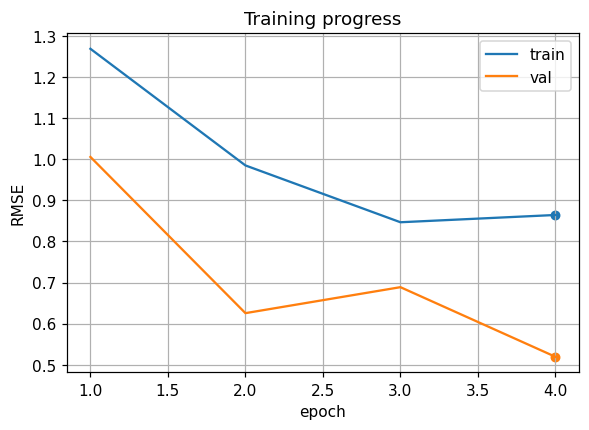

Epoch 001:   0%|                                                                                | 0/64 [00:00<…

I0000 00:00:1750269978.258700   12293 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 001 • train=1.268338 • val=1.005418 • impr=-240.6% • lr=3.75e-04 • g≈3386.35


Epoch 002:   0%|                                                                                | 0/64 [00:00<…

Epoch 002 • train=0.984784 • val=0.625688 • impr=-112.0% • lr=4.55e-05 • g≈21664.95


Epoch 003:   0%|                                                                                | 0/64 [00:00<…

Epoch 003 • train=0.846660 • val=0.688830 • impr=-133.4% • lr=3.44e-04 • g≈2458.72


Epoch 004:   0%|                                                                                | 0/64 [00:00<…

Epoch 004 • train=0.864327 • val=0.519567 • impr=-76.0% • lr=1.61e-04 • g≈5374.35


In [ ]:
###############################################################################
# FULL  TRAIN–SAVE  PIPELINE  – prints baseline + %-improvement               #
###############################################################################
import math, numpy as np, tensorflow as tf
from datetime import datetime
from pathlib import Path

# ─────────────────────────────────────────────────────────────────────────────
# 0.  ONE-OFF  :  baseline on the untouched validation split
# ─────────────────────────────────────────────────────────────────────────────
def naive_rmse(ds_val):
    """RMSE when the forecast is always zero."""
    mse, n = 0.0, 0
    for _, y_day, _ in ds_val:
        y = y_day.numpy().squeeze()
        mse += np.sum(y ** 2)
        n   += y.size
    return math.sqrt(mse / n)

baseline_val_rmse = naive_rmse(ds_val_unbatched)
print(f"Baseline (predict-zero) RMSE on validation = {baseline_val_rmse:.6f}")

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Training loop (outer bar only → maximum throughput)                     #
# ─────────────────────────────────────────────────────────────────────────────
n_train_days = len(np.unique(day_id_tr))
print(f"Training sees {n_train_days} calendar days per epoch\n")

best_val_rmse = custom_stateful_training_loop(
        model_train         = model_train,
        model_val           = model_val,
        ds_train_batched    = ds_train_batched,
        ds_val              = ds_val_unbatched,
        n_train_days        = n_train_days,
        max_epochs          = MAX_EPOCHS,
        early_stop_patience = EARLY_STOP_PATIENCE,
        baseline_val_rmse   = baseline_val_rmse,
        ckpt_path           = ckpt_path)

print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")
print(f"Improvement vs baseline   = {(1 - best_val_rmse/baseline_val_rmse)*100:5.1f} %")

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Sync FP32 twin  +  refresh checkpoint                                   #
# ─────────────────────────────────────────────────────────────────────────────
model_val.set_weights(model_train.get_weights())
model_val.save_weights(ckpt_path)

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Persist architecture + weights  (.keras)                                #
# ─────────────────────────────────────────────────────────────────────────────
today     = datetime.now().strftime("%Y-%m-%d")
file_path = save_dir / f"model_{ticker}_{today}.keras"
model_val.save(file_path)
print("\nModel & weights saved to", file_path)
